# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Цель** данного проектам - определить регион, где добыча принесёт наибольшую прибыль

**Задачи** для достижения поставленное цели:

1. Обучить и проверите модель для каждого региона
2. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
3. Посчитать риски и прибыль для каждого региона техникой *Bootstrap*

**Описание данных:**
- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек
- product — объём запасов в скважине (тыс. баррелей) - наш таргет

## Импорт библиотек

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


%config InlineBackend.figure_format='retina'

warnings.filterwarnings("ignore")

Заранее устанавливаем число для рандомизаторов

In [2]:
RANDOM_STATE = np.random.RandomState(42)

## Загрузка и подготовка данных

In [3]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
region_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
region_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
def get_duplicates(df):
    num_duplicates = df.duplicated().sum()
    print("Количество дубликатов в датафрейме: ", num_duplicates)

In [9]:
get_duplicates(region_1)
get_duplicates(region_2)
get_duplicates(region_3)

Количество дубликатов в датафрейме:  0
Количество дубликатов в датафрейме:  0
Количество дубликатов в датафрейме:  0


In [10]:
def get_dataset_short_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для отображения короткой информации по датасету. Аналог функции df.info()

    Args:
        df (pd.DataFrame): Датафрейм с исходным датасетом

    Returns:
        pd.DataFrame: Возвращает датафрейм с описанием данных
    """

    shape = df.shape[0]
    columns = ['column', 'count_values', 'unique_values', '% unique',
               'missing', '% missing', 'dtype']
    rows = []
    for col in df.columns:
        rows.extend([[
            col,  # название столбца
            df[col].count(),  # кол-во НЕ пустых значений
            df[col].nunique(),  # кол-во уникальных значений
            str(round(df[col].nunique() * 100 / df[col].count(), 2)) + '%',
            # доля уникальных значений
            df[col].isna().sum(),  # кол-во пропущенных значений
            str(round((1 - (df[col].count() / shape)), 1) * 100) + '%',
            # доля пропущенных значений
            str(df[col].dtype),  # тип данных
            ]]) 
    info = pd.DataFrame(data=rows, columns=columns).sort_values(
        by=['% missing', 'missing'], ascending=False).round(4)
    return info




In [11]:
display(get_dataset_short_info(region_1))
display(get_dataset_short_info(region_2))
display(get_dataset_short_info(region_3))

,column,count_values,unique_values,% unique,missing,% missing,dtype
0,id,100000,99990,99.99%,0,0.0%,object
1,f0,100000,100000,100.0%,0,0.0%,float64
2,f1,100000,100000,100.0%,0,0.0%,float64
3,f2,100000,100000,100.0%,0,0.0%,float64
4,product,100000,100000,100.0%,0,0.0%,float64


,column,count_values,unique_values,% unique,missing,% missing,dtype
0,id,100000,99996,100.0%,0,0.0%,object
1,f0,100000,100000,100.0%,0,0.0%,float64
2,f1,100000,100000,100.0%,0,0.0%,float64
3,f2,100000,100000,100.0%,0,0.0%,float64
4,product,100000,12,0.01%,0,0.0%,float64


,column,count_values,unique_values,% unique,missing,% missing,dtype
0,id,100000,99996,100.0%,0,0.0%,object
1,f0,100000,100000,100.0%,0,0.0%,float64
2,f1,100000,100000,100.0%,0,0.0%,float64
3,f2,100000,100000,100.0%,0,0.0%,float64
4,product,100000,100000,100.0%,0,0.0%,float64


- Во всех таблицах отсутствуют пропущенные значения.
- Столбец 'id' имеет тип данных object и содержит уникальные значения.
- Столбцы 'f0', 'f1', и 'f2' имеют тип данных float64 и содержат 100% уникальных значений.
- Столбец 'product' имеет различное количество уникальных значений в таблицах. В таблицах 1 и 3 все значения уникальны, а в таблице 2 только 12 уникальных значений (0.01%).

In [12]:
def corr_matrix(df):
    correlation_matrix = df.corr()

    plt.figure(figsize=(8, 8))

    sns.heatmap(
        correlation_matrix,
        annot=True,          
        cmap="coolwarm",    
        vmin=-1, vmax=1,     
        square=True,         
        linewidths=0.5,      
    )

    plt.title("Тепловая карта корреляции признаков")
    plt.show()

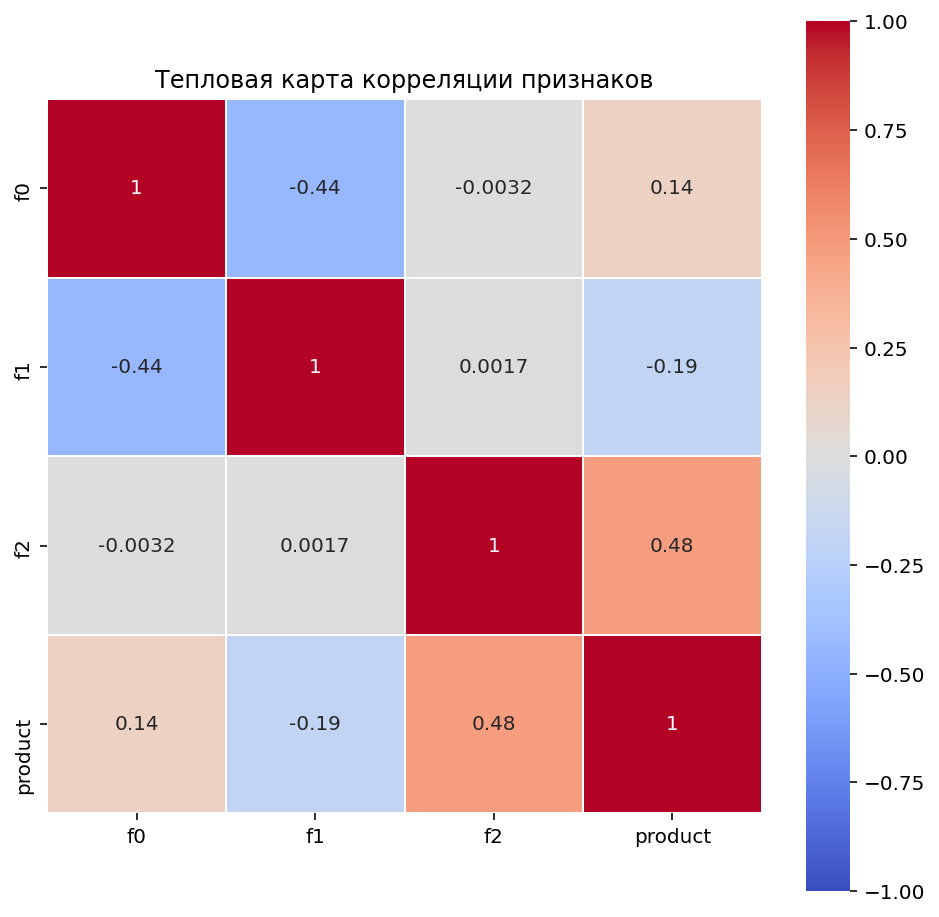

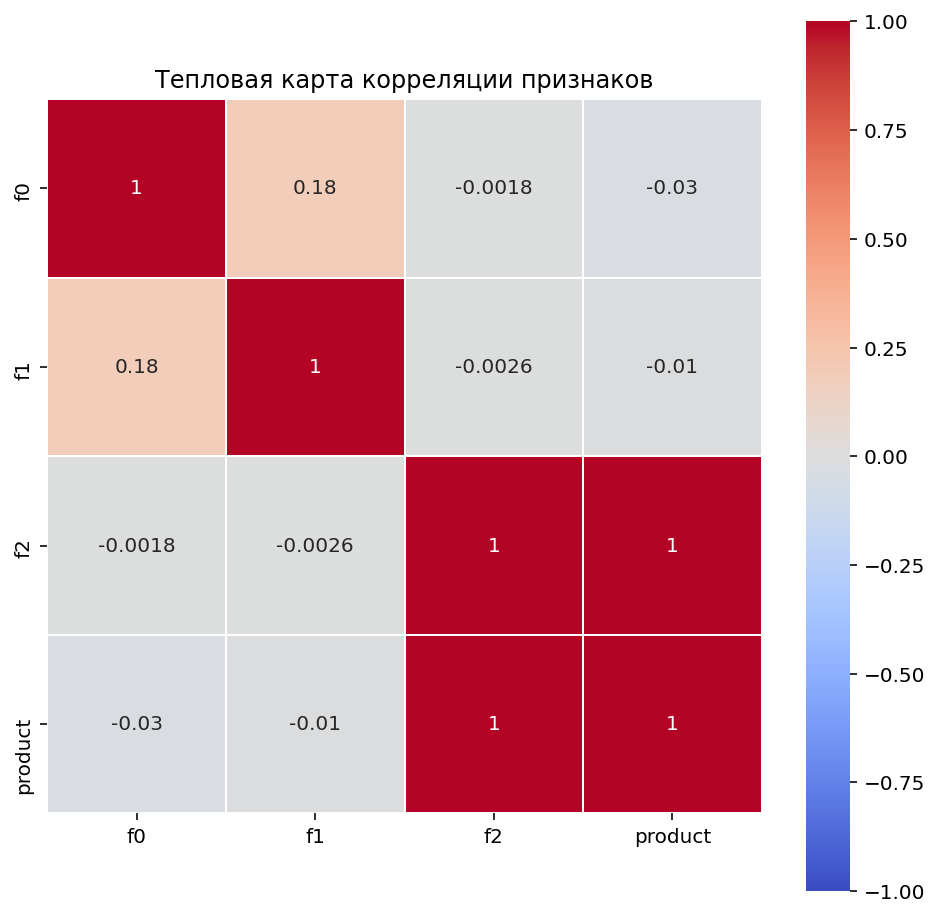

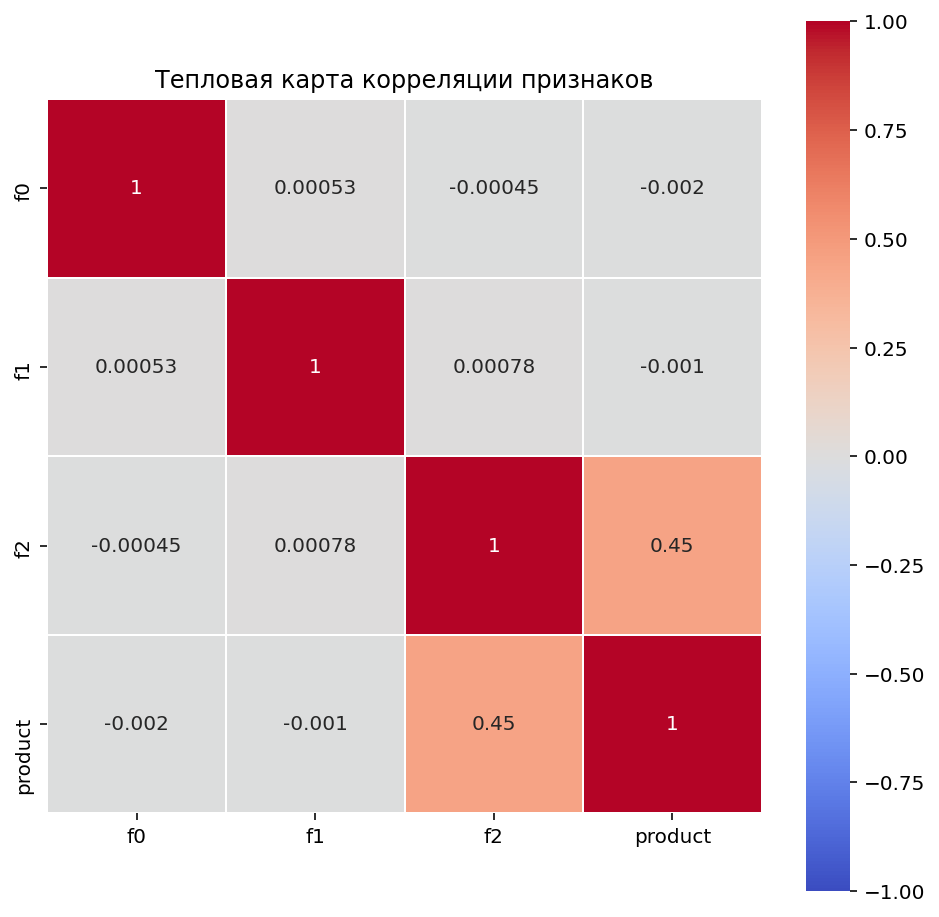

In [13]:
corr_matrix(region_1)
corr_matrix(region_2)
corr_matrix(region_3)

Корреляция между f2 и product: 0.9993969704906555


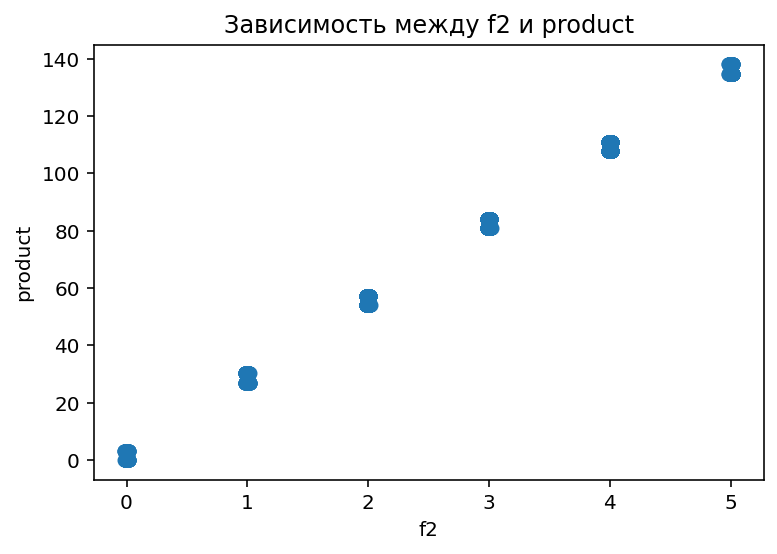

                  f2        product
count  100000.000000  100000.000000
mean        2.494541      68.825000
std         1.703572      45.944423
min        -0.018144       0.000000
25%         1.000021      26.953261
50%         2.011479      57.085625
75%         3.999904     107.813044
max         5.019721     137.945408
Константа (f2 / product): [-0.00184832  0.03707094  0.03710987 ...  0.03623644  0.03319177
 -0.00103756]


In [14]:
# Рассчитайте корреляцию между столбцами f2 и product
correlation = region_2['f2'].corr(region_2['product'])
print(f"Корреляция между f2 и product: {correlation}")

# Визуализация данных
plt.scatter(region_2['f2'], region_2['product'])
plt.xlabel('f2')
plt.ylabel('product')
plt.title('Зависимость между f2 и product')
plt.show()

print(region_2[['f2', 'product']].describe())

constant = region_2['f2'] / region_2['product']
print("Константа (f2 / product):", constant.unique())


Исходя из предоставленных статистических характеристик и значений константы (f2 / product), можно сделать следующие выводы:

- Распределение значений f2 и product имеет разный масштаб. Среднее значение f2 составляет 2.49, а для product - 68.83. Стандартное отклонение f2 равно 1.70, а для product - 45.94. Это может указывать на то, что корреляция между f2 и product не является искусственной или ошибочной.
- Значения константы (f2 / product) варьируются и не ограничиваются одним значением. Это указывает на то, что f2 не является просто произведением product на некоторую константу.

Таким образом, исходя из проведенного анализа, можно заключить, что f2 действительно имеет сильную корреляцию с product, и эта корреляция не является искусственной или ошибочной. Также f2 не является прямым определителем product или производной от него.

Теперь, когда мы установили, что f2 является действительным и независимым признаком, сильно коррелированным с product, его можно использовать для построения модели машинного обучения.

**Вывод:**

Как мы видим, у нас нет пропусков, в 1 и 3 регионе все отлично, во 2 регионе мы можем увидеть мультиколлениарность. Это может привести к нестабильности и неправильной интерпретации коэффициентов регрессии. Мультиколлениарность может ухудшить производительность моделей машинного обучения, особенно линейных регрессионных моделей, но в нашем случае можно испольщовать признак f2. 


Для дальнейшего обучения модели нам стоит отбросить идентификатор, а атрибут product будет являться нашим целевым значением, который мы и должны предсказать. 

## Обучение и проверка модели

Напишем функцию для обучения модели и подсчета метрики регрессии


In [15]:
def training_model(dataframe: pd.DataFrame) -> pd.Series:
    
    # Разделяем данные на признаки и таргет
    features = dataframe.drop(['product', 'id'], axis=1)
    target = dataframe['product']
    
    # Разделяем данные на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, 
                                                          random_state=RANDOM_STATE)
    
    # Масштабирование признаков
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)

    X_valid_scaled = scaler.transform(X_valid)
    
    
    # Инициализируем класс линейной регрессии
    logreg = LinearRegression()
    
    # Обучаем модель, делаем предсказания и складываем их в объект Series для удобства
    logreg.fit(X_train_scaled, y_train)
    
    predicted = logreg.predict(X_valid_scaled)
    
    # Считаем метрику RMSE через функцию mean_squared_error
    mse = mean_squared_error(y_valid, predicted)
    rmse = mse**0.5
    
    X_valid['predictions'] = np.hstack([predicted])
    
    predicted = X_valid['predictions']
    
    mean_predicted = predicted.mean()
    
    print(f'Средний предсказанный запас - {mean_predicted} тыс. бар., RMSE - {rmse}')
    
    # Возвращаем в качестве результата работы функции предсказанные значения
    return y_valid, predicted

Теперь запустим обучение для каждого из регионов и посмотрим на результаты

In [16]:
reg_1_true, reg_1_pred = training_model(region_1)

Средний предсказанный запас - 92.39879990657768 тыс. бар., RMSE - 37.75660035026169


In [17]:
reg_2_true, reg_2_pred = training_model(region_2)

Средний предсказанный запас - 68.58780312701154 тыс. бар., RMSE - 0.8899472027156131


In [18]:
reg_3_true, reg_3_pred = training_model(region_3)

Средний предсказанный запас - 95.09230341410031 тыс. бар., RMSE - 40.23735038140562


Результаты получились противоречивыми. 1 и 3 регион показывают более высокое значение среднего предсказанного запаса, но при этом у 2 региона метрика RMSE максимально близка к 0

## Подготовка к расчёту прибыли

In [19]:
# Кол-во точек для разведки в регионе
TOTAL_SCOUTING = 500

# Кол-во точек, которые будут определяться как наиболее лучшие для разработки
TOP_SCOUTING = 200

# Бюджет на разработку скважин в регионе
BUDGET= 10000000000

# Доход с одного барреля сырья
ONE_BURREL= 450

# Доход с каждой единицы продукта
ONE_PRODUCT= 450000

Посчитаем сколько необходимо запаса сырья в одной скважине для преодоления порога бюджета. Для этого разделим бюджет на стоимость единицы продукта и на кол-во точек, которые будут определяться как наиболее лучшие для разработки

In [20]:
one_well_minimum_profit = BUDGET / ONE_PRODUCT / TOP_SCOUTING
one_well_minimum_profit

111.11111111111111

Получаем 111. Для проверки округлим до 112. Сколько принесет прибыли, если в среднем запас сырья на одной скважине 112 тыс. бар.

In [21]:
112 * ONE_PRODUCT * TOP_SCOUTING - BUDGET

80000000

In [22]:
111 * ONE_PRODUCT * TOP_SCOUTING - BUDGET

-10000000

Получем 80 миллионов рублей. Если подставить просто число 111, то получим убыток в 10 млн рублей

Если сравнить нааш минимальный порог прибыльности с предсказаниями модели, то можно увидеть, что все 3 региона далеки от порога безубыточности. Но стоит заметить, что для конечно расчета прибыли берется 200 наиболее лушчих скважин, поэтому объективные данные по прибыльности регионов мы увидим дальше

**Вывод**

Если в среднем запас сырья на одной скважине больше или равен 112 тыс. бар., то регион можно считать прибыльным и его стоит начать разрабатывать

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли. Механизм расчета следующий:
1. Берем предсказанные значения по каждой из скважин
2. Сортируем значения по убыванию и выбираем топ 200 значений
3. Суммируем все значения кол-ва сырья
4. Умножаем полученную сумму на доход с 1 единицы продукта и вычитаем затраты на разработку

In [23]:
def profit_calculation(predicted_values_in_region: pd.Series, true_values_in_region: pd.Series) -> float:
    sorted_values = predicted_values_in_region.sort_values(ascending=False).head(TOP_SCOUTING)
    true_values = true_values_in_region[sorted_values.index]
    sum_of_top_values = true_values.sum()
    profit = sum_of_top_values * ONE_PRODUCT - BUDGET
    
    return profit

## Bootstrap

Теперь применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Для этого напишем функцию, со следующей механикой:
- Функция принимает на вход данные по предсказанным значениям запаса сырья в регионе
- В цикле на 1000 повторений:
    - выделяется подвыборка в 500 значений
    - по каждому значению считается прибыль
    - посчитанная прибыль записывается в массив `profit_dict`, где будут храниться все прибыли
    - если в очередной итерация прибыль получилась отрицательная мы записываем такой объект в массив `loss_dict`
- Массив в посчитанными значениями прибыли преобразовывается в объект Series
- Считается средняя прибыль и 95% квантиль, а также риск убытков

In [24]:
def bootstrap_check(predicted_values_in_region: pd.Series, true_values_in_region: pd.Series):

    # Создаем DataFrame с предсказанными и реальными значениями
    data = pd.concat([predicted_values_in_region, true_values_in_region], axis=1)
    data.columns = ['predicted', 'true']

    # Создаем списки
    profit_dict = []
    loss_dict = []

    # Делаем 1000 итераций подсчета прибыли с подвыборкой в 500 единиц из предсказанных значений
    for i in range(1000):
        data_sample = data.sample(n=TOTAL_SCOUTING, replace=True, random_state=RANDOM_STATE)
        calc_profit = profit_calculation(data_sample['predicted'], data_sample['true'])
        profit_dict.append(calc_profit)

        if calc_profit < 0:
            loss_dict.append(calc_profit)

    # Преобразовываем в объект Series
    values = pd.Series(profit_dict)

    # Считаем метрики
    mean_profit = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    loss_count = len(loss_dict)

    # Выводим результат
    print(f'Средняя прибыль: {mean_profit:.3f}')
    print('Кол-во убыточных:', loss_count)
    print(f'Вероятность убытков: {loss_count/1000*100:.3f}%')
    print(f'95% доверительный интервал: {lower:.3f} - {upper:.3f}')

    # Отрисовываем гистограмму
    plt.figure(figsize=(16, 8))

    sns.kdeplot(data=values)
    plt.axvline(x=lower, color='red', linestyle='--', label='Начало интервала')
    plt.axvline(x=upper, color='green', linestyle='--', label='Конец интервала')
    plt.axvline(x=mean_profit, color='crimson', linestyle='--', label='Средняя прибыль по Bootstrap')

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.ylabel('Плотность распределения', fontsize=16)
    plt.xlabel('Прибыль', fontsize=16)

    plt.legend(loc="upper left")
    plt.title('Распределение прибыли по Bootstrap', fontsize=20)
    plt.show()


### Регион 1

Средняя прибыль: 620900554.782
Кол-во убыточных: 25
Вероятность убытков: 2.500%
95% доверительный интервал: 1421765.518 - 1281857739.333


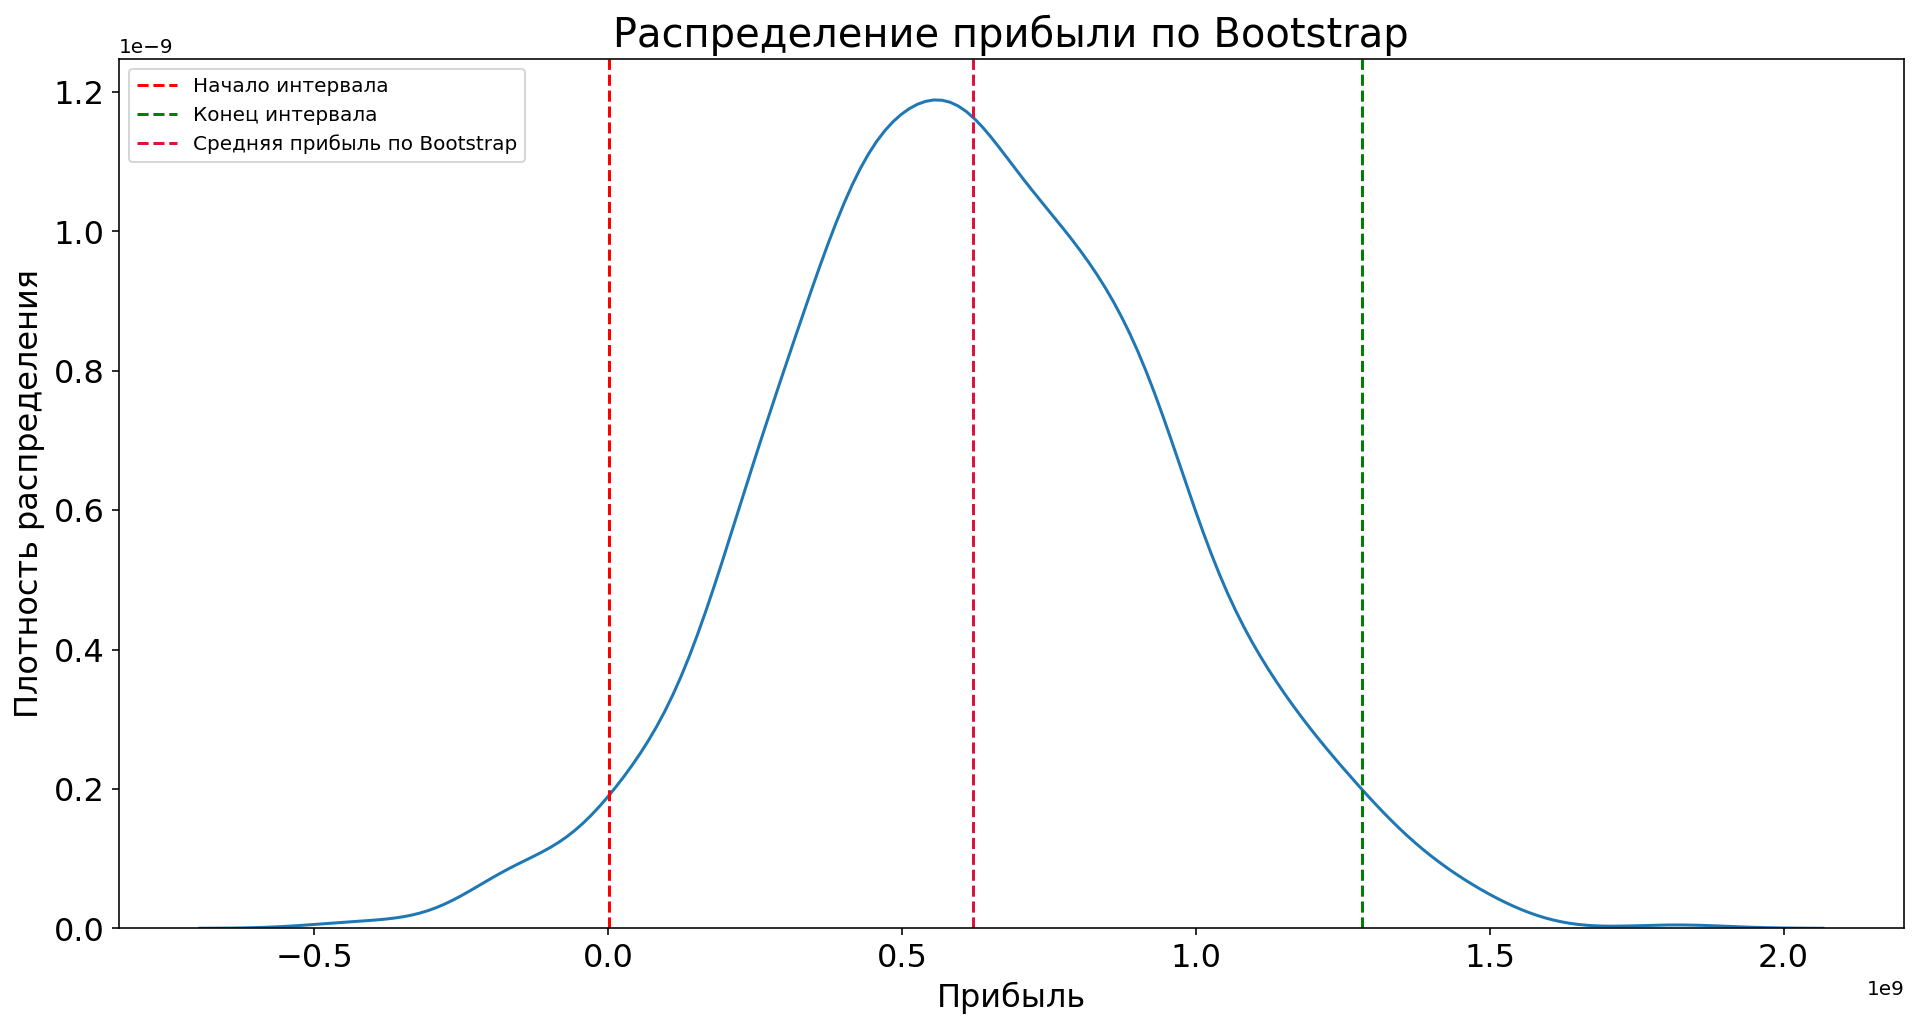

In [25]:
bootstrap_check(reg_1_pred, reg_1_true)

### Регион 2

Средняя прибыль: 641528304.830
Кол-во убыточных: 4
Вероятность убытков: 0.400%
95% доверительный интервал: 165124357.178 - 1148458624.396


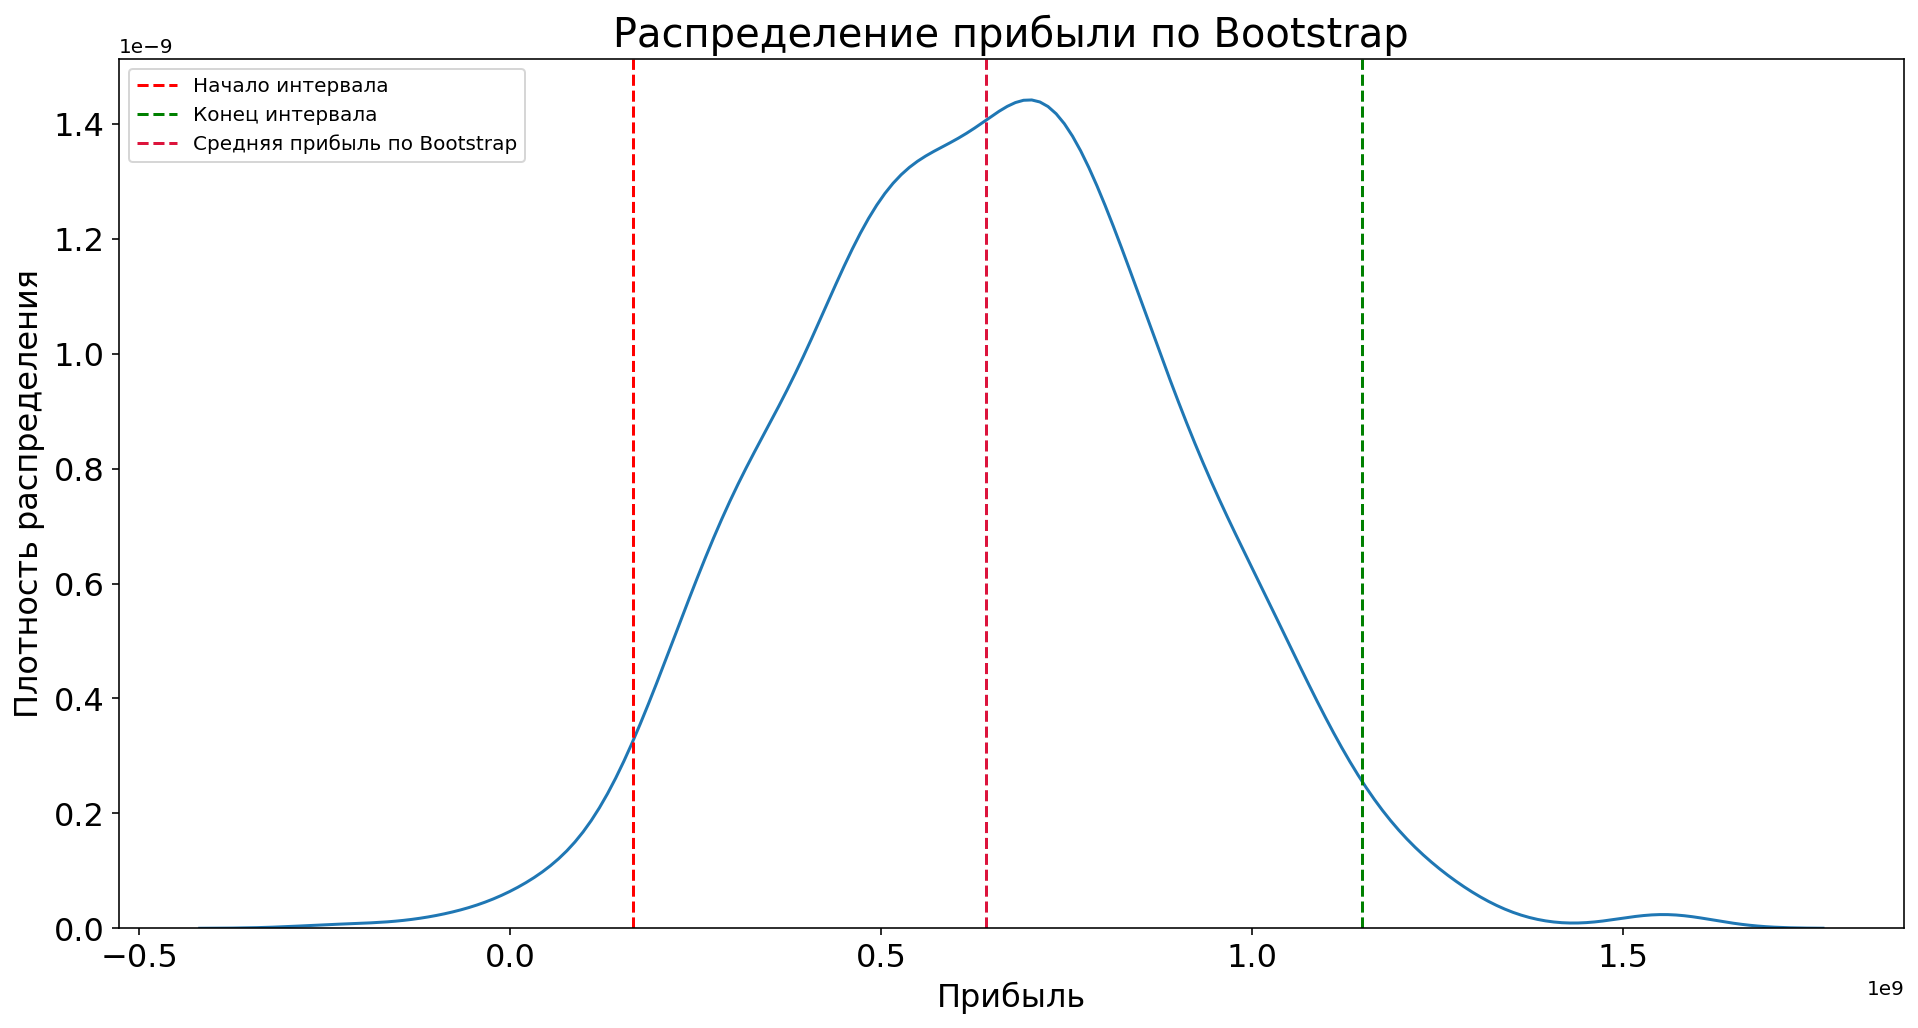

In [26]:
bootstrap_check(reg_2_pred, reg_2_true)

### Регион 3

Средняя прибыль: 528607667.812
Кол-во убыточных: 49
Вероятность убытков: 4.900%
95% доверительный интервал: -86436108.643 - 1176269696.528


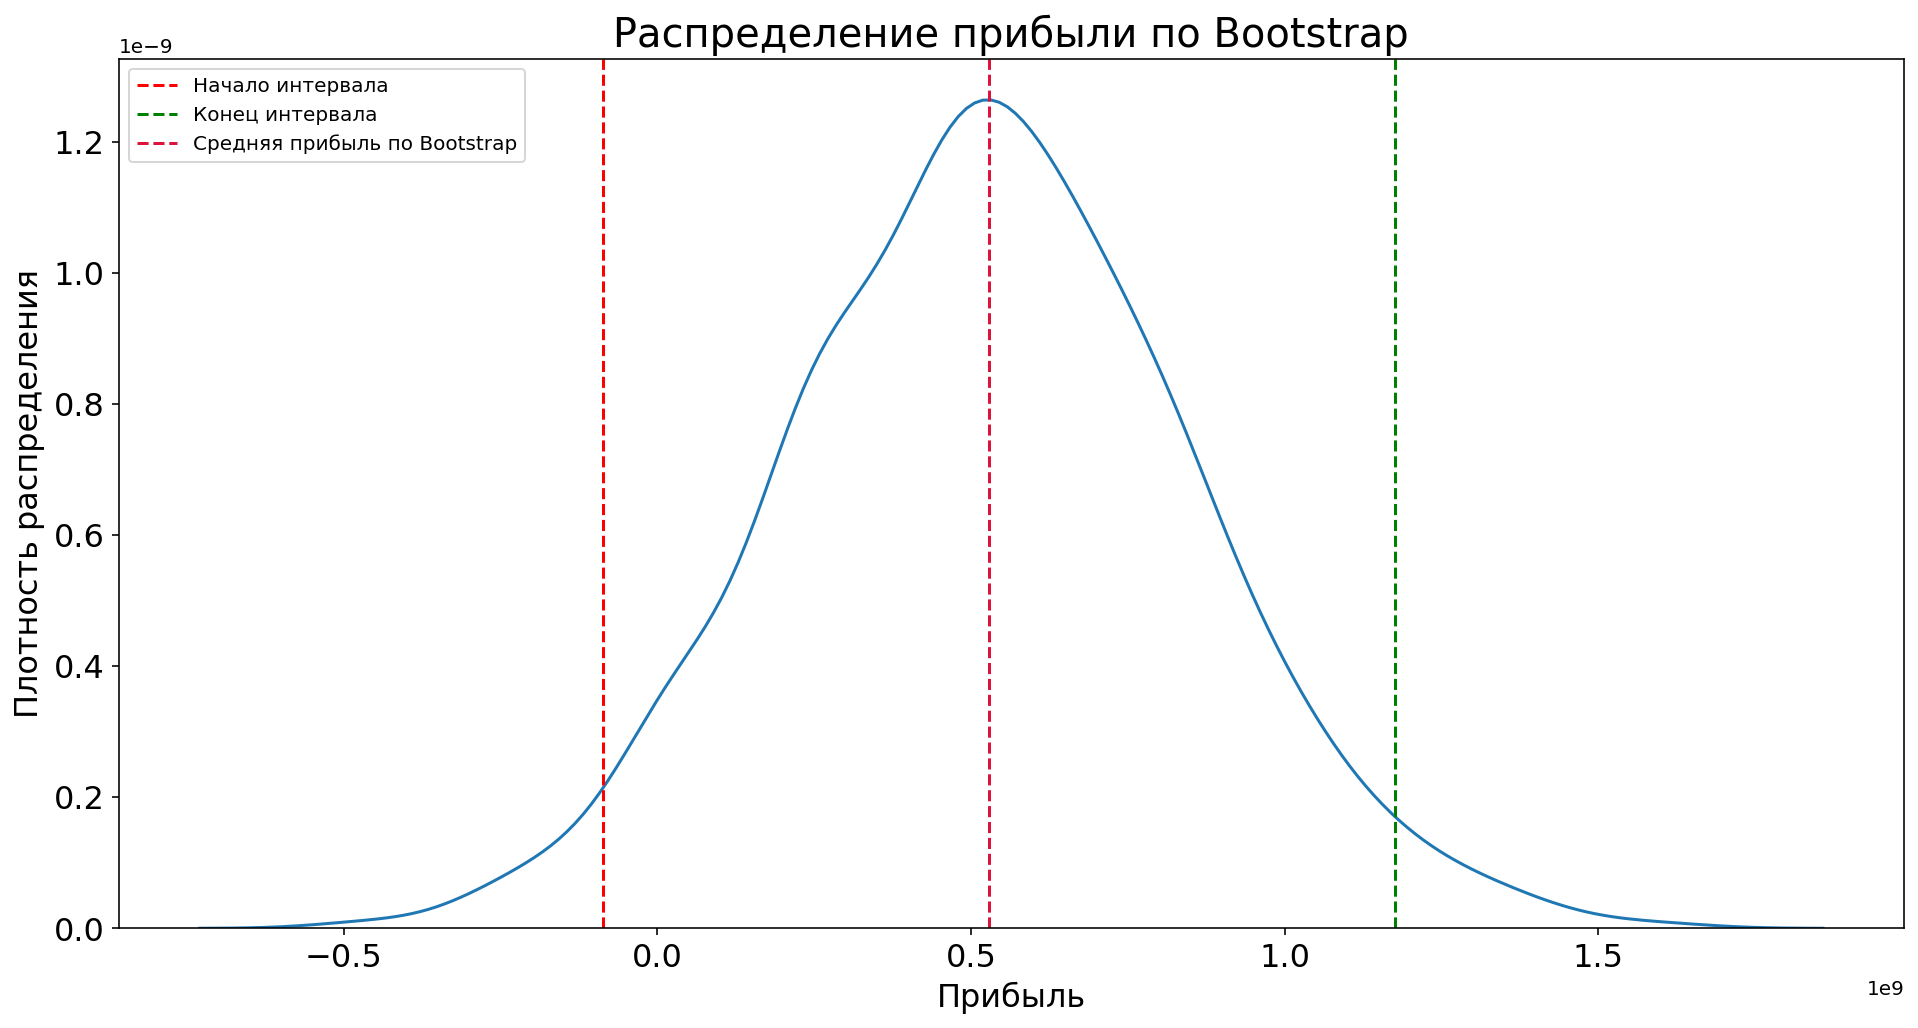

In [27]:
bootstrap_check(reg_3_pred, reg_3_true)

По итогам расчета с Bootstrap можно сказать, что 1 и 3 регион нас не устраивает ввиду превышения уровня по вероятности убытка. В итоге, наиболее прибыльным оказался регион 2. (так как 2.5% в 1 регионе не меньше 2.5%)

Средняя прибыль этого региона составила 641 млн рублей.

## Выводы

В результате данного проекта нам удалось достигнуть поставленную цель и найти перспективный регион для начала разработки месторождений.

В рамках исследования было рассмотрена 3 различных региона со своими уникальными параметрами. Для каждого из регионов по этим параметрам была построена модель линейной регрессии для предсказания кол-ва сырья на каждой из точек. Впоследствии для каждого из регионов была посчитана потенциальная прибыль.

Для того, чтобы удостовериться в результатах исследования была использована техника Bootstrap для того, чтобы найти распределение прибыли, среднюю прибыль, 95%-й доверительный интервал и риск убытков.

По итогам применения Boostrap можем сказать, что для нашей компании самый перспективный с точки зрения прибыли и минимизации рисков регион - регион №2